In [1]:
from pathlib import Path
import numpy as np

import quantem as em
from quantem.core import config
from quantem.core.datastructures import Dataset4dstem
from quantem.diffractive_imaging.dataset_models import PtychographyDatasetRaster
# from quantem.diffractive_imaging.pftm import PFTM, PFTM_DIP
from quantem.core.visualization import show_2d

from quantem.core import config
from quantem.core.datastructures import Dataset4dstem
from quantem.core.visualization.visualization import show_2d
from quantem.diffractive_imaging.dataset_models import PtychographyDatasetRaster
from quantem.diffractive_imaging.detector_models import DetectorPixelated
from quantem.diffractive_imaging.object_models import ObjectDIP, ObjectPixelated
from quantem.diffractive_imaging.probe_models import ProbePixelated
from quantem.diffractive_imaging.ptychography import Ptychography
from quantem.core.utils.diffractive_imaging_utils import fit_probe_circle

config.set_device(0)
print(config.get("device"))


/home/rotelimelech/differential_ptycho/quantem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
import pickle

with open(r"/home/rotelimelech/differential_ptycho/data/hbn_ptycho_datacubes_checkerboard.pkl", 'rb') as f:
    data = pickle.load(f)

data.keys()

dict_keys(['acc_voltage', 'conv_angle_mrad', 'defocus_A', 'merged_scan', 'scan_mask', 'scan_sampling'])

In [3]:
data['scan_sampling']

0.2

In [4]:
PROBE_ENERGY = data['acc_voltage']
PROBE_SEMIANGLE = data['conv_angle_mrad']
PROBE_DEFOCUS = data['defocus_A']
# SCAN_STEP_SIZE = SCAN_STEP_SIZE # data['scan_sampling'] 

NUM_PROBES = 1
NUM_SLICES = 1 
SLICE_THICKNESS = 1 # A

In [5]:
SCAN_STEP_SIZE = 0.39285714285714285

In [6]:
merged_scan = data['merged_scan']
scan_mask = data['scan_mask']
scan_sampling = data['scan_sampling']


# Sanity check - only take one object channel and run the algo to check for convergence

In [7]:
single_sample_ch = merged_scan[::2,::2, ...]
scan_mask_single_ch = scan_mask[::2,::2, ...].copy()
print(single_sample_ch.shape, merged_scan.shape)
print(np.all(scan_mask_single_ch == 1)) # show that it is indeed a single channel
scan_mask_single_ch[:,:] = 0  # since we only have one channel, make sure that the mask choices only that channel

(28, 28, 128, 128) (56, 56, 128, 128)
True


In [8]:
SCAN_STEP_SIZE

0.39285714285714285

In [9]:
dset = Dataset4dstem.from_array(
    single_sample_ch,
    name='single_channel',
    sampling=(SCAN_STEP_SIZE, SCAN_STEP_SIZE, 1, 1),
    units=("A", "A", "pixels", "pixels")
)

In [10]:
PROBE_DEFOCUS, PROBE_ENERGY, PROBE_SEMIANGLE

(30, 60000.0, 20)

Forcing best fit rotation to 0 degrees.
Forcing transpose of intensities to False.


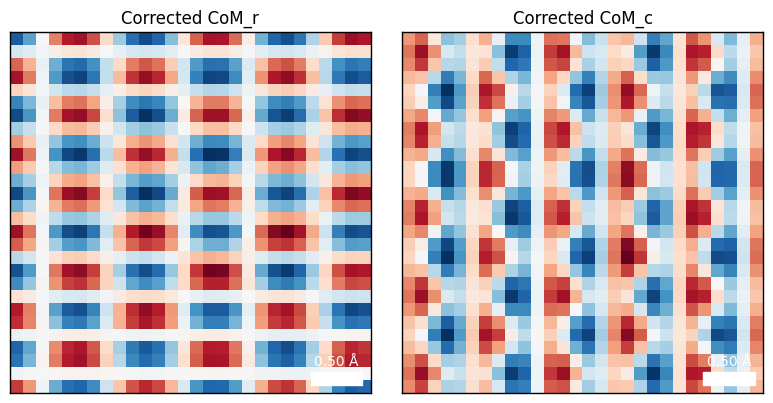

Normalizing intensities: 100%|██████████| 784/784 [00:01<00:00, 601.25probe position/s]


In [11]:
probe_qy0, probe_qx0, probe_R = fit_probe_circle(dset.dp_mean.array, show=False)
dset.sampling[2] = PROBE_SEMIANGLE / probe_R
dset.sampling[3] = PROBE_SEMIANGLE / probe_R
dset.units[2:] = ["mrad", "mrad"]
probe_R = PROBE_SEMIANGLE / dset.sampling[2]
# print(dset)

pdset = PtychographyDatasetRaster.from_dataset4dstem(dset)
pdset.preprocess(
    com_fit_function="constant",
    plot_rotation=False,
    plot_com=True,
    probe_energy=PROBE_ENERGY,
    force_com_rotation=0, 
    force_com_transpose=False,
)    

probe_params = {
    "energy" : PROBE_ENERGY,
    "defocus" : PROBE_DEFOCUS,
    "semiangle_cutoff" : PROBE_SEMIANGLE, 
}
detector_model = DetectorPixelated() 

# Set up ptychography model for excited state
probe_model = ProbePixelated.from_params(
    num_probes=1,
    probe_params=probe_params,
)

In [12]:
import torch
from quantem.diffractive_imaging.object_models import ObjectMultiplexed
import importlib
import quantem.diffractive_imaging.object_models as om

importlib.reload(om)
from quantem.diffractive_imaging.object_models import ObjectMultiplexed

obj_model = ObjectMultiplexed.from_uniform(
    num_slices=NUM_SLICES, 
    slice_thicknesses=SLICE_THICKNESS,
    obj_type='pure_phase',
    num_channels=1,
    patches_mask=torch.tensor(scan_mask_single_ch)
)

In [13]:
ptycho = Ptychography.from_models(
    dset=pdset,
    obj_model=obj_model,
    probe_model=probe_model,
    detector_model=detector_model,
    device='cuda',
)

ptycho.preprocess( 
    obj_padding_px=(16, 16),
    batch_size=128,
)

/home/rotelimelech/differential_ptycho/quantem/src/quantem/diffractive_imaging/object_models.py:1260: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:309.)
  post_constraint_obj[ch] = self.apply_hard_constraints(


In [14]:
lr = 1e-2
obj_lr = 1e-1
probe_lr = 1e-3
tv_weight = 1

opt_params = { # except type, all args are passed to the optimizer (of type type)
    "object": {
        "type": "adam", 
        "lr": obj_lr
        , 
    },
    "probe": {
        "type": "adam", 
        "lr": probe_lr, 
    },
    # "dataset": { ### for optimizing over descan shifts and probe positions
    #     "type": "adam",
    #     "lr": 1e-4,
    # }
}

scheduler_params = {
    "object": { ## scheduler kwargs are passed to the scheduler (of type type)
        # "type": "exp",
        # "factor": 0.1,
        "type": "plateau", ## i like plateau for many cases
    },
    "probe": {
        # "type": "exp",
        "type": "plateau",
        # "threshold": 1e-2, # e.g. plateau kwargs 
        # "patience": 100,
        # "cooldown": 100,
    },
    # "dataset": { 
    #     "type": "exp",  ## exp is also frequently used 
    #     "factor": 0.1,
    # }
}

constraints = {
    "object": {
        # "tv_weight_xy": tv_weight, ## these are mostly the defaults 
        # "tv_weight_z": 0.,
        "fix_potential_baseline": False,
        "identical_slices": True, ## default for this is False 
        "apply_fov_mask": False,
    },
    "probe": {
        "center_probe": False,
        "orthogonalize_probe": True,
    },
    "dataset":{
        "descan_tv_weight": 0,
        "descan_shifts_constant": False, 
    }
}

In [15]:
ptycho.reconstruct(
    num_iters=25,
    reset=True,
    autograd=True, 
    device='cuda',
    constraints=constraints, 
    optimizer_params=opt_params,
    scheduler_params=scheduler_params,
    batch_size=64,
    multichannel_mode=True,
) # .visualize()

Iter 25/25, Loss: 9.786e-02: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


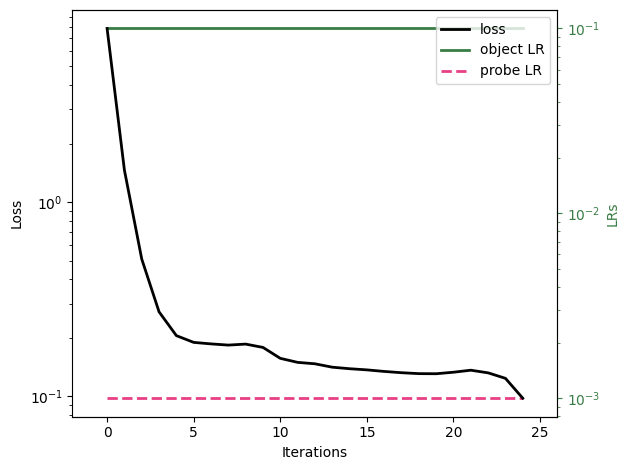

In [16]:
ptycho.plot_losses()

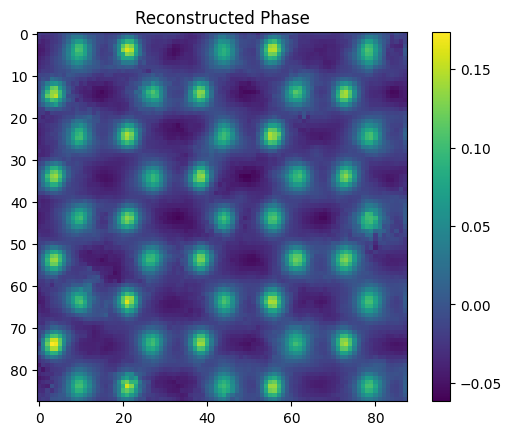

In [17]:
from matplotlib import pyplot as plt
recon_phase = ptycho.obj_model.obj[0,0,...].angle().detach().cpu().numpy()
plt.imshow(recon_phase[16:-16,16:-16])
plt.colorbar()
plt.title("Reconstructed Phase")
plt.show()

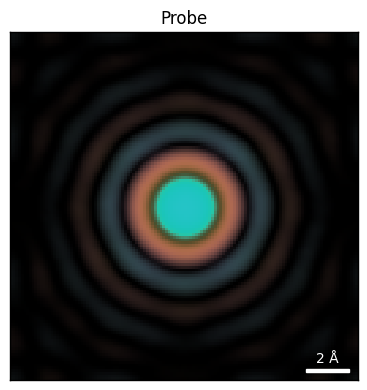

In [18]:
ptycho.show_probe()

# Multichannel recon

In [20]:
dset = Dataset4dstem.from_array(
    merged_scan,
    name='merged_scan',
    sampling=(SCAN_STEP_SIZE/2, SCAN_STEP_SIZE/2, 1, 1),
    units=("A", "A", "pixels", "pixels")
)

In [21]:
probe_qy0, probe_qx0, probe_R = fit_probe_circle(dset.dp_mean.array, show=False)
dset.sampling[2] = PROBE_SEMIANGLE / probe_R
dset.sampling[3] = PROBE_SEMIANGLE / probe_R
dset.units[2:] = ["mrad", "mrad"]
probe_R = PROBE_SEMIANGLE / dset.sampling[2]
# print(dset)


pdset = PtychographyDatasetRaster.from_dataset4dstem(dset)
pdset.preprocess(
    com_fit_function="constant",
    plot_rotation=False,
    plot_com=False,
    probe_energy=PROBE_ENERGY,
    force_com_rotation=0, 
    force_com_transpose=False,
)    

probe_params = {
    "energy" : PROBE_ENERGY,
    "defocus" : PROBE_DEFOCUS,
    "semiangle_cutoff" : PROBE_SEMIANGLE, 
}
detector_model = DetectorPixelated() 

# Set up ptychography model for excited state
probe_model = ProbePixelated.from_params(
    num_probes=1,
    probe_params=probe_params,
)


Forcing best fit rotation to 0 degrees.
Forcing transpose of intensities to False.


Normalizing intensities: 100%|██████████| 3136/3136 [00:05<00:00, 612.54probe position/s]


In [22]:
import torch
from quantem.diffractive_imaging.object_models import ObjectMultiplexed
import importlib
import quantem.diffractive_imaging.object_models as om

importlib.reload(om)
from quantem.diffractive_imaging.object_models import ObjectMultiplexed

obj_model = ObjectMultiplexed.from_uniform(
    num_slices=NUM_SLICES, 
    slice_thicknesses=SLICE_THICKNESS,
    obj_type='pure_phase',
    num_channels=2,
    patches_mask=torch.tensor(scan_mask)
)

In [24]:
ptycho = Ptychography.from_models(
    dset=pdset,
    obj_model=obj_model,
    probe_model=probe_model,
    detector_model=detector_model,
    device='cuda',
)

ptycho.preprocess( 
    obj_padding_px=(16, 16),
    batch_size=32,
)


In [25]:
lr = 1e-2
obj_lr = 1e-1
probe_lr = 1e-3
tv_weight = 1

opt_params = { # except type, all args are passed to the optimizer (of type type)
    "object": {
        "type": "adam", 
        "lr": obj_lr
        , 
    },
    "probe": {
        "type": "adam", 
        "lr": probe_lr, 
    },
    # "dataset": { ### for optimizing over descan shifts and probe positions
    #     "type": "adam",
    #     "lr": 1e-4,
    # }
}

scheduler_params = {
    "object": { ## scheduler kwargs are passed to the scheduler (of type type)
        # "type": "exp",
        # "factor": 0.1,
        "type": "plateau", ## i like plateau for many cases
    },
    "probe": {
        # "type": "exp",
        "type": "plateau",
        # "threshold": 1e-2, # e.g. plateau kwargs 
        # "patience": 100,
        # "cooldown": 100,
    },
    # "dataset": { 
    #     "type": "exp",  ## exp is also frequently used 
    #     "factor": 0.1,
    # }
}

constraints = {
    "object": {
        # "tv_weight_xy": tv_weight, ## these are mostly the defaults 
        # "tv_weight_z": 0.,
        "fix_potential_baseline": False,
        "identical_slices": True, ## default for this is False 
        "apply_fov_mask": False,
    },
    "probe": {
        "center_probe": False,
        "orthogonalize_probe": True,
    },
    "dataset":{
        "descan_tv_weight": 0,
        "descan_shifts_constant": False, 
    }
}

In [ ]:
ptycho.reconstruct(
    num_iters=25,
    reset=True,
    autograd=True, 
    device='cuda',
    constraints=constraints, 
    optimizer_params=opt_params,
    scheduler_params=scheduler_params,
    batch_size=128,
    multichannel_mode=True,
) # .visualize()


  0%|          | 0/25 [00:00<?, ?it/s]

In [20]:
ptycho.reconstruct(10)

Iter 10/10, Loss: 9.572e-01: 100%|██████████| 10/10 [01:11<00:00,  7.11s/it]


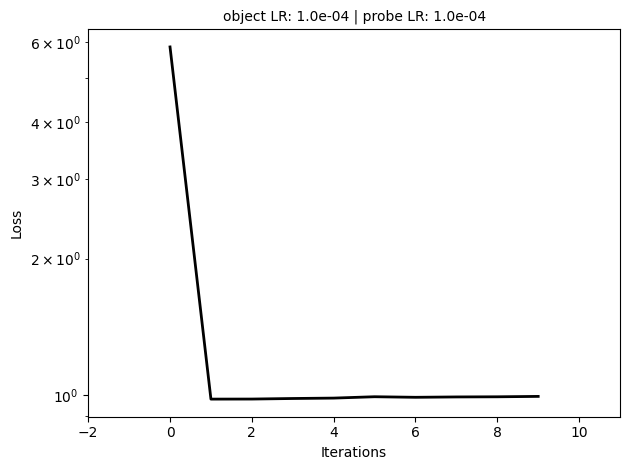

In [26]:
ptycho.plot_losses()

In [27]:
recon_off = np.angle(ptycho.obj_model.obj[0,0,...].cpu().detach().cpu().numpy())
recon_on = np.angle(ptycho.obj_model.obj[1,0,...].cpu().detach().cpu().numpy())


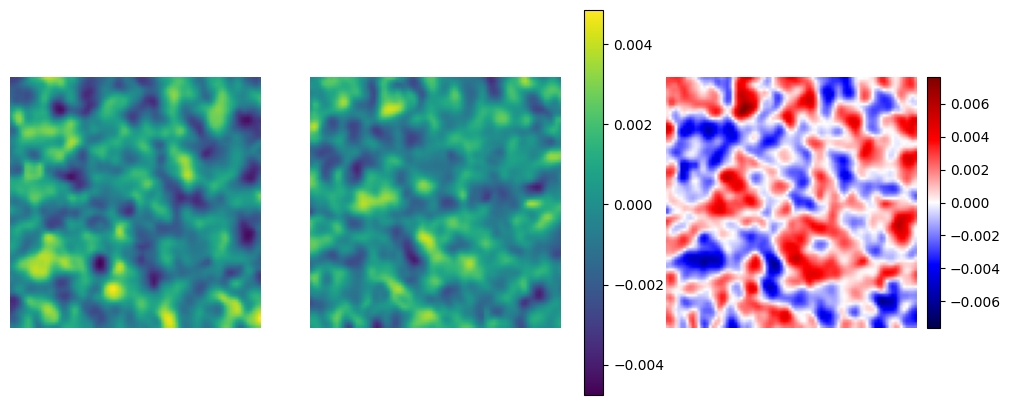

In [28]:
from visualizers import plot_image_diffs
plot_image_diffs(recon_off[16:-16,16:-16], recon_on[16:-16,16:-16])

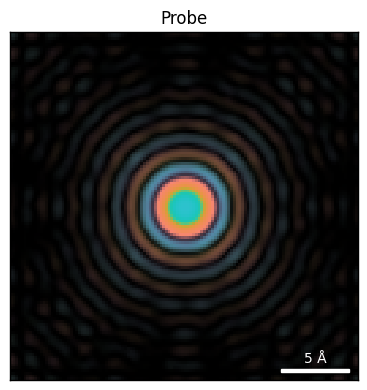

In [102]:
ptycho.show_probe()

In [57]:
# scan for best lrs 
def do_ptycho(obj_lr, probe_lr):
    opt_params = { # except type, all args are passed to the optimizer (of type type)
        "object": {
            "type": "adam", 
            "lr": obj_lr
            , 
        },
        "probe": {
            "type": "adam", 
            "lr": probe_lr, 
        },
    }

    ptycho.reconstruct(
        num_iters=5,
        reset=True,
        autograd=True, 
        device='cuda',
        constraints=constraints, 
        optimizer_params=opt_params,
        scheduler_params=scheduler_params,
        batch_size=16,
    ) # .visualize()
    return ptycho.iter_losses

for obj_lr in np.logspace(-2, -7, 6):
    for probe_lr in np.logspace(-2, -7, 6):
        losses = do_ptycho(obj_lr, probe_lr)
        print(f"obj_lr: {obj_lr:.1e}, probe_lr: {probe_lr:.1e}, final loss: {losses[-1]:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Iter 5/5, Loss: 1.346e+01: 100%|██████████| 5/5 [00:35<00:00,  7.17s/it]


obj_lr: 1.0e-02, probe_lr: 1.0e-02, final loss: 13.4567


  0%|          | 0/5 [00:00<?, ?it/s]


KeyboardInterrupt: 

array([1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07])